In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import galsim
import cv2 as cv
from scipy.signal import convolve2d
import tensorflow as tf

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

tf.version.VERSION

'1.15.0'

In [2]:
dat = np.load('Data/Cat-SFG-17-01-2020.npz')
img1 = np.abs(fits.open('Data/psf2asec-96.psf.fits')[0].data[0,0,:,:])

#gal = cv.resize(dat['listgal'][299,:,:], (64,64))
gal = np.random.randn(64,64)
#psf = cv.resize(galsim.Image(img1, copy=True).array, (64,64))
psf = np.random.randn(64,64)
psf /= np.sum(psf)

gal_fft = np.fft.fftshift(np.fft.fft2(gal))   
psf_fft = np.fft.fftshift(np.fft.fft2(psf))      

# SNR(x) = l2_norm(x)/sigma_noise 
SNR = 1.0e2                                                       # Signal to noise ratio in Fourier domain
sigma_noise = np.linalg.norm(gal_fft)/SNR                         # Standard deviation of noise

gal_fft_GSO = galsim.Image(gal_fft, copy=True)                    # Stored as GSO
gal_fft_GSO.addNoise(galsim.GaussianNoise(sigma = sigma_noise)) 

pad = 20        # Padding to remove aliasing
conv_padded = np.pad(gal_fft_GSO.array, pad) * np.pad(psf_fft, pad)
conv = conv_padded[pad:conv_padded.shape[0]-pad, pad:conv_padded.shape[1]-pad]

final_gal = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(conv))))  # IFFT to get back to brightness domain
final_gal = final_gal * (np.sum(gal)/np.sum(final_gal))                     # Normalisation

In [3]:
gal_tf = tf.cast(gal, dtype='complex128')
psf_tf = tf.cast(psf, dtype='complex128')

final_gal_tf = tf.cast(final_gal, dtype='complex128')

n_iter = 100

def gen_kernel():
    shape = final_gal.shape
    dirac = np.zeros(shape)
    dirac[shape[0]//2, shape[1]//2] = 1
    gauss_kernel = cv.GaussianBlur(dirac, (5,5), 0)
    return gauss_kernel

In [4]:
np.sum(tf.keras.backend.get_value(gal_tf) - gal)

0j

In [5]:
np.sum(tf.keras.backend.get_value(psf_tf) - psf)

0j

In [6]:
np.sum(tf.keras.backend.get_value(final_gal_tf) - final_gal)

0j

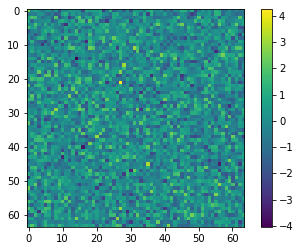

In [7]:
plt.imshow(gal)
plt.colorbar()

## Comparison

In [8]:
def proj_tf(xi):
    return tf.cast(tf.math.maximum(tf.math.real(xi), 0.0), dtype='complex128')

def proj_np(xi):
    xi = np.maximum(xi,0)
    return xi


SNR = 40                                                       
sigma_noise = np.linalg.norm(gal)/SNR 
gal_noise = gal + sigma_noise * np.random.randn(*gal.shape)
gal_noise_tf = tf.cast(gal_noise, dtype='complex128')

a = proj_tf(gal_noise_tf)
b = proj_np(gal_noise)

np.sum(np.abs(tf.keras.backend.get_value(a) - b))

0.0

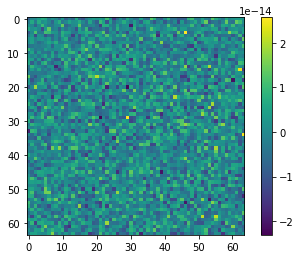

In [9]:
def fftconvolve_tf(image, kernel):
    x = tf.signal.fftshift(tf.signal.fft2d(image))
    y = tf.signal.fftshift(tf.signal.fft2d(kernel))
    result = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(tf.signal.ifftshift(x * y))))
    return tf.cast(result, dtype='complex128')

def fftconvolve_np(image, kernel):
    x = np.fft.fftshift(np.fft.fftn(image))
    y = np.fft.fftshift(np.fft.fftn(kernel))
    return np.real(np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(x * y))))


a = fftconvolve_tf(gal_tf, psf_tf)
b = fftconvolve_np(gal, psf)

plt.imshow(np.real(tf.keras.backend.get_value(a) - b))
plt.colorbar()

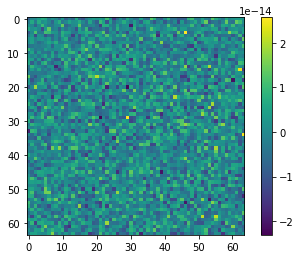

In [10]:
def H_tf(data, psf):
    return fftconvolve_tf(data, psf)

def H_np(data, psf):
    return fftconvolve_np(data, psf)

a = H_tf(gal_tf, psf_tf)
b = H_np(gal, psf)

plt.imshow(np.real(tf.keras.backend.get_value(a) - b))
plt.colorbar()

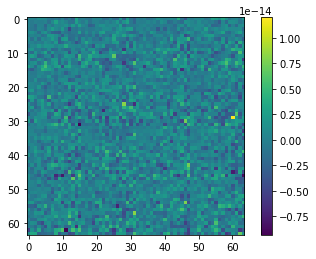

In [11]:
def fft_tf(data):
    return ( tf.convert_to_tensor(1.0/data.get_shape().as_list()[0], dtype='complex128') * 
             tf.signal.fftshift(tf.signal.fft2d(tf.signal.ifftshift(data))) )

def fft_np(data):
    return (1 / np.sqrt(data.size) *
            np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(data))))


a = fft_tf(gal_tf)
b = fft_np(gal)

plt.imshow(np.real(tf.keras.backend.get_value(a) - b))
plt.colorbar()

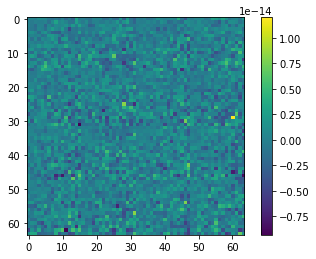

In [12]:
def ifft_tf(data):
    return ( tf.convert_to_tensor(data.get_shape().as_list()[0], dtype='complex128') *
             tf.signal.fftshift(tf.signal.ifft2d(tf.signal.ifftshift(data))) )

def ifft_np(data):
    return (np.sqrt(data.size) *
            np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(data))))

a = ifft_tf(gal_tf)
b = ifft_np(gal)

plt.imshow(np.real(tf.keras.backend.get_value(a) - b))
plt.colorbar()

0j


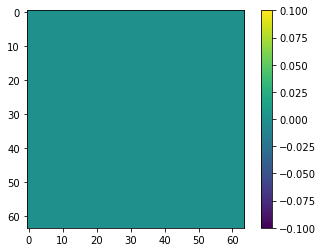

In [13]:
def soft_thresh_tf(data, threshold):
    return tf.cast((1.0 - threshold/tf.math.abs(data)), dtype='complex128') * data

def soft_thresh_np(data, threshold):
    return (1.0 - threshold/np.abs(data)) * data

a = soft_thresh_tf(gal_tf, 1e-10)
b = soft_thresh_np(gal, 1e-10)

plt.imshow(np.real(tf.keras.backend.get_value(a) - b))
plt.colorbar()

print(np.sum(tf.keras.backend.get_value(a) - b))

In [14]:
def nmse_tf(signal_1, signal_2):
    return tf.keras.backend.get_value(tf.norm(signal_2 - signal_1)**2 / tf.norm(signal_1)**2)

def nmse_np(signal_1, singal_2):
    return (np.linalg.norm(singal_2 - signal_1) ** 2 /
            np.linalg.norm(signal_1) ** 2)


a = nmse_tf(gal_tf, psf_tf)
b = nmse_np(gal, psf)

tf.keras.backend.get_value(a) - b

(1.5543122344752192e-15+0j)

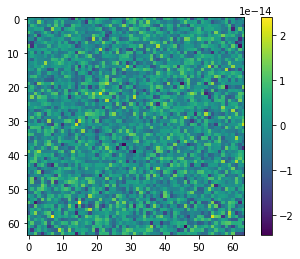

In [15]:
def Ht_tf(data, psf):
    return fftconvolve_tf(data, tf.reverse(tf.reverse(psf, axis=[0]), axis=[1]))      

def Ht_np(data, psf):
    return fftconvolve_np(data, np.rot90(psf, 2))

a = Ht_tf(gal_tf, psf_tf)
b = Ht_np(gal, psf)

plt.imshow(np.real(tf.keras.backend.get_value(a) - b))
plt.colorbar()

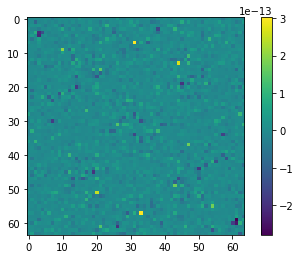

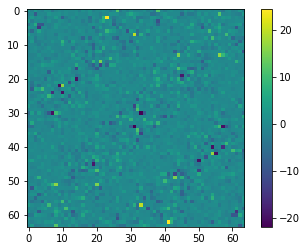

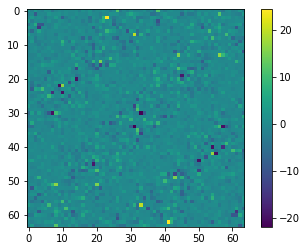

In [16]:
def grad_tf(y, x_rec, psf):
    return ifft_tf(Ht_tf(H_tf(fft_tf(x_rec), psf) - y, psf))

def grad_np(y, x_rec, psf):
    return ifft_np(Ht_np(H_np(fft_np(x_rec), psf) - y, psf))

x_rec = gal + np.random.randn(*gal.shape)

a = grad_tf(gal_tf, tf.cast(x_rec, dtype='complex128'), psf_tf)
b = grad_np(gal, x_rec, psf)

plt.imshow(np.real(tf.keras.backend.get_value(a) - b))
plt.colorbar()
plt.show()

plt.imshow(np.real(tf.keras.backend.get_value(a)))
plt.colorbar()
plt.show()

plt.imshow(np.real(b))
plt.colorbar()
plt.show()

In [17]:
def cost_func_tf(y, x_rec, z, mu, rho, psf, var=1.0):
    temp = z - x_rec
    shape = mu.get_shape().as_list()
    cost_val = ( tf.cast(0.5, dtype='complex128') * rho * tf.norm(temp)**2  -
                 tf.matmul(tf.reshape(mu, [1, shape[0]*shape[1]]), tf.reshape(temp, [shape[0]*shape[1], 1]))  +
                 tf.cast(0.5/var, dtype='complex128') * tf.norm(y - H_tf(fft_tf(x_rec), psf))**2 )
    return cost_val

def cost_func_np(y, x_rec, z, mu, rho, psf, var=1.0):
    cost_val = (0.5*rho*np.linalg.norm(z-x_rec)**2 - 
                np.dot(mu.flatten(), (z-x_rec).flatten()) + 
                (0.5/var)*np.linalg.norm(y - H_np(fft_np(x_rec), psf))**2)
    return cost_val


x_rec_np = gal + np.random.randn(*gal.shape)
x_rec_tf = tf.cast(x_rec_np, dtype='complex128')

z_np = np.zeros(gal.shape) 
z_tf = tf.cast(z_np, dtype='complex128')

mu_np = np.random.randn(*gal.shape)
mu_tf = tf.cast(mu_np, dtype='complex128')

rho_np = 50.0
rho_tf = tf.cast(50.0, dtype='complex128')                            


a = cost_func_tf(final_gal_tf, x_rec_tf, z_tf, mu_tf, rho_tf, psf_tf)
b = cost_func_np(final_gal, x_rec_np, z_np, mu_np, rho_np, psf)


res = tf.keras.backend.get_value(a) - b
print(res)

[[2.91038305e-11+0.j]]


In [18]:
def max_sv_tf(psf):
    H = tf.signal.fft2d(psf)
    normH = tf.math.abs(tf.math.conj(H) * H)
    return tf.cast(tf.math.reduce_max(normH), dtype='complex128')

def max_sv_np(psf):
    H = np.fft.fft2(psf)
    normH = np.abs(H.conj() * H)
    return np.max(normH)


a = max_sv_tf(gal_tf)
b = max_sv_np(gal)

tf.keras.backend.get_value(a) - b

(2.1100277081131935e-10+0j)